In [1526]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import os
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [364]:
yf.pdr_override()
sp500 = pdr.get_data_yahoo('SPY', start='2010-12-01', end='2020-12-31')
sp500

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-11-30,119.169998,117.809998,117.980003,118.489998,233930700.0,94.234497
2010-12-01,121.239998,120.190002,120.199997,121.010002,221037200.0,96.238647
2010-12-02,122.650002,121.129997,121.199997,122.559998,191213600.0,97.471344
2010-12-03,123.029999,122.110001,122.139999,122.889999,151288900.0,97.733795
2010-12-06,123.040001,122.500000,122.629997,122.760002,103050500.0,97.630417
...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,26457900.0,359.978149
2020-12-28,372.589996,371.070007,371.739990,372.170013,39000400.0,363.070587
2020-12-29,374.000000,370.829987,373.809998,371.459991,53680500.0,362.377991


In [366]:
sp500['Volume'] = sp500['Volume']/np.power(10,5)
sp500

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-11-30,119.169998,117.809998,117.980003,118.489998,2339.307,94.234497
2010-12-01,121.239998,120.190002,120.199997,121.010002,2210.372,96.238647
2010-12-02,122.650002,121.129997,121.199997,122.559998,1912.136,97.471344
2010-12-03,123.029999,122.110001,122.139999,122.889999,1512.889,97.733795
2010-12-06,123.040001,122.500000,122.629997,122.760002,1030.505,97.630417
...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,264.579,359.978149
2020-12-28,372.589996,371.070007,371.739990,372.170013,390.004,363.070587
2020-12-29,374.000000,370.829987,373.809998,371.459991,536.805,362.377991


In [367]:
indicators = ['Close', 'Volume']
symbol_lag_list = []
lag = 14
sp500_lagged = sp500.copy()
for indicator in indicators:
    for i in range(1, lag):
        sp500_lagged[f'{indicator}_{i}'] = sp500_lagged[indicator].shift(i)
sp500_lagged

,High,Low,Open,Close,Volume,Adj Close,Close_1,Close_2,Close_3,Close_4,...,Volume_4,Volume_5,Volume_6,Volume_7,Volume_8,Volume_9,Volume_10,Volume_11,Volume_12,Volume_13
Date,,,,,,,,,,,,,,,,,,,,,
2010-11-30,119.169998,117.809998,117.980003,118.489998,2339.307,94.234497,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-01,121.239998,120.190002,120.199997,121.010002,2210.372,96.238647,118.489998,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-02,122.650002,121.129997,121.199997,122.559998,1912.136,97.471344,121.010002,118.489998,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-03,123.029999,122.110001,122.139999,122.889999,1512.889,97.733795,122.559998,121.010002,118.489998,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-12-06,123.040001,122.500000,122.629997,122.760002,1030.505,97.630417,122.889999,122.559998,121.010002,118.489998,...,2339.307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,264.579,359.978149,367.570007,367.239990,367.859985,369.179993,...,1365.423,641.195,584.205,638.653,692.162,576.986,577.354,740.983,424.589,489.443
2020-12-28,372.589996,371.070007,371.739990,372.170013,390.004,363.070587,369.000000,367.570007,367.239990,367.859985,...,963.867,1365.423,641.195,584.205,638.653,692.162,576.986,577.354,740.983,424.589
2020-12-29,374.000000,370.829987,373.809998,371.459991,536.805,362.377991,372.170013,369.000000,367.570007,367.239990,...,479.490,963.867,1365.423,641.195,584.205,638.653,692.162,576.986,577.354,740.983


In [1459]:
sp500_train = sp500_lagged.loc['2011-01-01':'2016-01-01']
sp500_test = sp500_lagged.loc['2016-01-01':]

In [1460]:
sp500_test['return'] = np.log(sp500_test.Close/sp500_test.Close.shift(1))
sp500_test['cumreturn'] = sp500_test['return'].cumsum().apply(np.exp)
sp500_test

C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\1606492981.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['return'] = np.log(sp500_test.Close/sp500_test.Close.shift(1))
C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\1606492981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['cumreturn'] = sp500_test['return'].cumsum().apply(np.exp)


,High,Low,Open,Close,Volume,Adj Close,Close_1,Close_2,Close_3,Close_4,...,Volume_6,Volume_7,Volume_8,Volume_9,Volume_10,Volume_11,Volume_12,Volume_13,return,cumreturn
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,201.029999,198.589996,200.490005,201.020004,2223.535,178.051300,203.869995,205.929993,207.399994,205.210007,...,1109.872,1110.262,990.943,2513.935,1730.925,1970.170,1540.696,1823.852,NaN,NaN
2016-01-05,201.899994,200.050003,201.399994,201.360001,1108.458,178.352448,201.020004,203.869995,205.929993,207.399994,...,485.396,1109.872,1110.262,990.943,2513.935,1730.925,1970.170,1540.696,0.001690,1.001691
2016-01-06,200.059998,197.600006,198.339996,198.820007,1521.126,176.102646,201.360001,201.020004,203.869995,205.929993,...,658.999,485.396,1109.872,1110.262,990.943,2513.935,1730.925,1970.170,-0.012694,0.989056
2016-01-07,197.440002,193.589996,195.330002,194.050003,2134.361,171.877686,198.820007,201.360001,201.020004,203.869995,...,926.407,658.999,485.396,1109.872,1110.262,990.943,2513.935,1730.925,-0.024284,0.965327
2016-01-08,195.850006,191.580002,195.190002,191.919998,2098.172,169.991058,194.050003,198.820007,201.360001,201.020004,...,633.177,926.407,658.999,485.396,1109.872,1110.262,990.943,2513.935,-0.011037,0.954731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,264.579,359.978149,367.570007,367.239990,367.859985,369.179993,...,584.205,638.653,692.162,576.986,577.354,740.983,424.589,489.443,0.003883,1.835638
2020-12-28,372.589996,371.070007,371.739990,372.170013,390.004,363.070587,369.000000,367.570007,367.239990,367.859985,...,641.195,584.205,638.653,692.162,576.986,577.354,740.983,424.589,0.008554,1.851408
2020-12-29,374.000000,370.829987,373.809998,371.459991,536.805,362.377991,372.170013,369.000000,367.570007,367.239990,...,1365.423,641.195,584.205,638.653,692.162,576.986,577.354,740.983,-0.001910,1.847876


In [1609]:
sp500_train['Close_Shifted'] = sp500_train['Close'].shift(-6)
sp500_train['Target'] = ((sp500_train.Close_Shifted-sp500_train.Open)/(sp500_train.Open)*100).shift(-1)
sp500_train['Target_Direction'] = np.where(sp500_train.Target > 0, 1, 0)
sp500_train['Target_Direction'] = np.where(sp500_train.Target < -sp500_train['Target'].std(), -1, sp500_train.Target_Direction)
sp500_train

C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\4135941119.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_train['Close_Shifted'] = sp500_train['Close'].shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\4135941119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_train['Target'] = ((sp500_train.Close_Shifted-sp500_train.Open)/(sp500_train.Open)*100).shift(-1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\4135941119.py:3: SettingWithCopyWarning: 
A value is trying to be set 

,High,Low,Open,Close,Volume,Adj Close,Close_1,Close_2,Close_3,Close_4,...,Volume_7,Volume_8,Volume_9,Volume_10,Volume_11,Volume_12,Volume_13,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,127.599998,125.699997,126.709999,127.050003,1387.252,101.573601,125.750000,125.720001,125.919998,125.830002,...,788.781,949.655,1190.855,1410.753,1850.352,1608.231,1472.496,127.430000,0.981701,1
2011-01-04,127.370003,126.190002,127.330002,126.980003,1374.097,101.517647,127.050003,125.750000,125.720001,125.919998,...,700.537,788.781,949.655,1190.855,1410.753,1850.352,1608.231,128.580002,1.414120,1
2011-01-05,127.720001,126.459999,126.580002,127.639999,1339.753,102.045296,126.980003,127.050003,125.750000,125.720001,...,581.260,700.537,788.781,949.655,1190.855,1410.753,1850.352,128.369995,1.260867,1
2011-01-06,127.830002,127.010002,127.690002,127.389999,1225.190,101.845436,127.639999,126.980003,127.050003,125.750000,...,553.091,581.260,700.537,788.781,949.655,1190.855,1410.753,129.300003,1.536537,1
2011-01-07,127.769997,126.150002,127.559998,127.139999,1560.346,101.645561,127.389999,127.639999,126.980003,127.050003,...,580.331,553.091,581.260,700.537,788.781,949.655,1190.855,129.520004,1.319322,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,206.330002,205.419998,205.720001,205.679993,485.396,182.178802,206.020004,203.500000,201.669998,200.020004,...,1540.696,1823.852,2111.733,1161.289,1624.015,1033.724,1020.271,NaN,NaN,0
2015-12-28,205.259995,203.940002,204.860001,205.210007,658.999,181.762512,205.679993,206.020004,203.500000,201.669998,...,1970.170,1540.696,1823.852,2111.733,1161.289,1624.015,1033.724,NaN,NaN,0
2015-12-29,207.789993,206.470001,206.509995,207.399994,926.407,183.702301,205.210007,205.679993,206.020004,203.500000,...,1730.925,1970.170,1540.696,1823.852,2111.733,1161.289,1624.015,NaN,NaN,0


In [1610]:
sp500_test['Close_Shifted'] = sp500_test['Close'].shift(-6)
sp500_test['Target'] = ((sp500_test.Close_Shifted-sp500_test.Open)/(sp500_test.Open)*100).shift(-1)
sp500_test['Target_Direction'] = np.where(sp500_test.Target > 0, 1, 0)
sp500_test['Target_Direction'] = np.where(sp500_test.Target < -sp500_test.Target.std(), -1, sp500_test.Target_Direction)
sp500_test

C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\2339419084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['Close_Shifted'] = sp500_test['Close'].shift(-6)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\2339419084.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['Target'] = ((sp500_test.Close_Shifted-sp500_test.Open)/(sp500_test.Open)*100).shift(-1)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\2339419084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

,High,Low,Open,Close,Volume,Adj Close,Close_1,Close_2,Close_3,Close_4,...,Volume_11,Volume_12,Volume_13,return,cumreturn,Close_Shifted,Target,Target_Direction,prediction,position
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,201.029999,198.589996,200.490005,201.020004,2223.535,178.051300,203.869995,205.929993,207.399994,205.210007,...,1970.170,1540.696,1823.852,NaN,NaN,193.660004,-6.241307,-1,1,1.0
2016-01-05,201.899994,200.050003,201.399994,201.360001,1108.458,178.352448,201.020004,203.869995,205.929993,207.399994,...,1730.925,1970.170,1540.696,0.001690,1.001691,188.830002,-3.231826,-1,1,0.0
2016-01-06,200.059998,197.600006,198.339996,198.820007,1521.126,176.102646,201.360001,201.020004,203.869995,205.929993,...,2513.935,1730.925,1970.170,-0.012694,0.989056,191.929993,-3.849897,-1,1,0.0
2016-01-07,197.440002,193.589996,195.330002,194.050003,2134.361,171.877686,198.820007,201.360001,201.020004,203.869995,...,990.943,2513.935,1730.925,-0.024284,0.965327,187.809998,-3.652854,-1,1,0.0
2016-01-08,195.850006,191.580002,195.190002,191.919998,2098.172,169.991058,194.050003,198.820007,201.360001,201.020004,...,1110.262,990.943,2513.935,-0.011037,0.954731,188.059998,-3.813274,-1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,264.579,359.978149,367.570007,367.239990,367.859985,369.179993,...,740.983,424.589,489.443,0.003883,1.835638,NaN,NaN,0,1,0.0
2020-12-28,372.589996,371.070007,371.739990,372.170013,390.004,363.070587,369.000000,367.570007,367.239990,367.859985,...,577.354,740.983,424.589,0.008554,1.851408,NaN,NaN,0,1,0.0
2020-12-29,374.000000,370.829987,373.809998,371.459991,536.805,362.377991,372.170013,369.000000,367.570007,367.239990,...,576.986,577.354,740.983,-0.001910,1.847876,NaN,NaN,0,0,0.0


In [1611]:
def create_model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=f'{os.getcwd()}\Conv1DFC_models\model_{model_name}',
                                              save_best_only=True)

In [1612]:
def create_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10)

In [1613]:
lagged_indicators = ['Close', 'Volume']
for indicator in indicators:
    for i in range(1, lag):
        lagged_indicators.append(f'{indicator}_{i}')
lagged_indicators

['Close',
 'Volume',
 'Close_1',
 'Close_2',
 'Close_3',
 'Close_4',
 'Close_5',
 'Close_6',
 'Close_7',
 'Close_8',
 'Close_9',
 'Close_10',
 'Close_11',
 'Close_12',
 'Close_13',
 'Volume_1',
 'Volume_2',
 'Volume_3',
 'Volume_4',
 'Volume_5',
 'Volume_6',
 'Volume_7',
 'Volume_8',
 'Volume_9',
 'Volume_10',
 'Volume_11',
 'Volume_12',
 'Volume_13']

In [1614]:
pre_train = sp500_train[:'2015-01-01']
pre_train

,High,Low,Open,Close,Volume,Adj Close,Close_1,Close_2,Close_3,Close_4,...,Volume_7,Volume_8,Volume_9,Volume_10,Volume_11,Volume_12,Volume_13,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,127.599998,125.699997,126.709999,127.050003,1387.252,101.573601,125.750000,125.720001,125.919998,125.830002,...,788.781,949.655,1190.855,1410.753,1850.352,1608.231,1472.496,127.430000,0.981701,1
2011-01-04,127.370003,126.190002,127.330002,126.980003,1374.097,101.517647,127.050003,125.750000,125.720001,125.919998,...,700.537,788.781,949.655,1190.855,1410.753,1850.352,1608.231,128.580002,1.414120,1
2011-01-05,127.720001,126.459999,126.580002,127.639999,1339.753,102.045296,126.980003,127.050003,125.750000,125.720001,...,581.260,700.537,788.781,949.655,1190.855,1410.753,1850.352,128.369995,1.260867,1
2011-01-06,127.830002,127.010002,127.690002,127.389999,1225.190,101.845436,127.639999,126.980003,127.050003,125.750000,...,553.091,581.260,700.537,788.781,949.655,1190.855,1410.753,129.300003,1.536537,1
2011-01-07,127.769997,126.150002,127.559998,127.139999,1560.346,101.645561,127.389999,127.639999,126.980003,127.050003,...,580.331,553.091,581.260,700.537,788.781,949.655,1190.855,129.520004,1.319322,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,208.339996,207.720001,208.020004,207.770004,429.634,180.309219,207.750000,207.470001,206.520004,206.779999,...,1899.658,2023.302,1590.128,1598.564,1251.801,1085.882,910.255,201.720001,-4.075652,-1
2014-12-26,208.850006,208.250000,208.309998,208.440002,573.267,180.890762,207.770004,207.750000,207.470001,206.520004,...,2595.438,1899.658,2023.302,1590.128,1598.564,1251.801,1085.882,199.820007,-2.838346,-1
2014-12-29,208.970001,208.139999,208.220001,208.720001,796.439,181.133682,208.440002,207.770004,207.750000,207.470001,...,2539.101,2595.438,1899.658,2023.302,1590.128,1598.564,1251.801,202.309998,-1.109463,0


In [1615]:
pretrain_x, pretrain_y = pre_train.loc[:, lagged_indicators], pre_train[['Target_Direction']].to_numpy()
cols = pretrain_x.columns
sorted_cols = [cols[0]] + cols[2:15].tolist() +[cols[1]] + cols[15:].tolist()
pretrain_x = pretrain_x.loc[:, sorted_cols]
encoder = OneHotEncoder()
pretrain_y = encoder.fit_transform(pretrain_y).todense()
pretrain_x

,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Volume_4,Volume_5,Volume_6,Volume_7,Volume_8,Volume_9,Volume_10,Volume_11,Volume_12,Volume_13
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,127.050003,125.750000,125.720001,125.919998,125.830002,125.650002,125.599998,125.779999,125.389999,124.599998,...,553.091,581.260,700.537,788.781,949.655,1190.855,1410.753,1850.352,1608.231,1472.496
2011-01-04,126.980003,127.050003,125.750000,125.720001,125.919998,125.830002,125.650002,125.599998,125.779999,125.389999,...,580.331,553.091,581.260,700.537,788.781,949.655,1190.855,1410.753,1850.352,1608.231
2011-01-05,127.639999,126.980003,127.050003,125.750000,125.720001,125.919998,125.830002,125.650002,125.599998,125.779999,...,766.169,580.331,553.091,581.260,700.537,788.781,949.655,1190.855,1410.753,1850.352
2011-01-06,127.389999,127.639999,126.980003,127.050003,125.750000,125.720001,125.919998,125.830002,125.650002,125.599998,...,912.189,766.169,580.331,553.091,581.260,700.537,788.781,949.655,1190.855,1410.753
2011-01-07,127.139999,127.389999,127.639999,126.980003,127.050003,125.750000,125.720001,125.919998,125.830002,125.650002,...,1387.252,912.189,766.169,580.331,553.091,581.260,700.537,788.781,949.655,1190.855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-24,207.770004,207.750000,207.470001,206.520004,206.779999,201.789993,197.910004,199.509995,200.889999,204.190002,...,2576.339,2539.101,2595.438,1899.658,2023.302,1590.128,1598.564,1251.801,1085.882,910.255
2014-12-26,208.440002,207.770004,207.750000,207.470001,206.520004,206.779999,201.789993,197.910004,199.509995,200.889999,...,2450.846,2576.339,2539.101,2595.438,1899.658,2023.302,1590.128,1598.564,1251.801,1085.882
2014-12-29,208.720001,208.440002,207.770004,207.750000,207.470001,206.520004,206.779999,201.789993,197.910004,199.509995,...,1483.189,2450.846,2576.339,2539.101,2595.438,1899.658,2023.302,1590.128,1598.564,1251.801


In [1616]:
val = sp500_train['2015-01-01':'2016-01-01']
val

,High,Low,Open,Close,Volume,Adj Close,Close_1,Close_2,Close_3,Close_4,...,Volume_7,Volume_8,Volume_9,Volume_10,Volume_11,Volume_12,Volume_13,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,206.880005,204.179993,206.380005,205.429993,1214.659,178.278519,205.539993,207.600006,208.720001,208.440002,...,1483.189,2450.846,2576.339,2539.101,2595.438,1899.658,2023.302,202.649994,-1.023655,0
2015-01-05,204.369995,201.350006,204.169998,201.720001,1696.326,175.058884,205.429993,205.539993,207.600006,208.720001,...,1221.679,1483.189,2450.846,2576.339,2539.101,2595.438,1899.658,202.080002,-0.608638,0
2015-01-06,202.720001,198.860001,202.089996,199.820007,2091.514,173.409958,201.720001,205.429993,205.539993,207.600006,...,429.634,1221.679,1483.189,2450.846,2576.339,2539.101,2595.438,200.860001,-1.191537,0
2015-01-07,202.720001,200.880005,201.419998,202.309998,1253.467,175.570908,199.820007,201.720001,205.429993,205.539993,...,573.267,429.634,1221.679,1483.189,2450.846,2576.339,2539.101,199.020004,-1.166604,0
2015-01-08,206.160004,203.990005,204.009995,205.899994,1472.178,178.686401,202.309998,199.820007,201.720001,205.429993,...,796.439,573.267,429.634,1221.679,1483.189,2450.846,2576.339,201.630005,-2.102711,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,206.330002,205.419998,205.720001,205.679993,485.396,182.178802,206.020004,203.500000,201.669998,200.020004,...,1540.696,1823.852,2111.733,1161.289,1624.015,1033.724,1020.271,NaN,NaN,0
2015-12-28,205.259995,203.940002,204.860001,205.210007,658.999,181.762512,205.679993,206.020004,203.500000,201.669998,...,1970.170,1540.696,1823.852,2111.733,1161.289,1624.015,1033.724,NaN,NaN,0
2015-12-29,207.789993,206.470001,206.509995,207.399994,926.407,183.702301,205.210007,205.679993,206.020004,203.500000,...,1730.925,1970.170,1540.696,1823.852,2111.733,1161.289,1624.015,NaN,NaN,0


In [1617]:
val_x,val_y = val.loc[:, lagged_indicators], val[['Target_Direction']].to_numpy()
val_x = val_x.loc[:, sorted_cols]
encoder = OneHotEncoder()
val_y = encoder.fit_transform(val_y).todense()
val_x

,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Volume_4,Volume_5,Volume_6,Volume_7,Volume_8,Volume_9,Volume_10,Volume_11,Volume_12,Volume_13
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,205.429993,205.539993,207.600006,208.720001,208.440002,207.770004,207.750000,207.470001,206.520004,206.779999,...,573.267,429.634,1221.679,1483.189,2450.846,2576.339,2539.101,2595.438,1899.658,2023.302
2015-01-05,201.720001,205.429993,205.539993,207.600006,208.720001,208.440002,207.770004,207.750000,207.470001,206.520004,...,796.439,573.267,429.634,1221.679,1483.189,2450.846,2576.339,2539.101,2595.438,1899.658
2015-01-06,199.820007,201.720001,205.429993,205.539993,207.600006,208.720001,208.440002,207.770004,207.750000,207.470001,...,735.408,796.439,573.267,429.634,1221.679,1483.189,2450.846,2576.339,2539.101,2595.438
2015-01-07,202.309998,199.820007,201.720001,205.429993,205.539993,207.600006,208.720001,208.440002,207.770004,207.750000,...,1303.338,735.408,796.439,573.267,429.634,1221.679,1483.189,2450.846,2576.339,2539.101
2015-01-08,205.899994,202.309998,199.820007,201.720001,205.429993,205.539993,207.600006,208.720001,208.440002,207.770004,...,1214.659,1303.338,735.408,796.439,573.267,429.634,1221.679,1483.189,2450.846,2576.339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,205.679993,206.020004,203.500000,201.669998,200.020004,204.860001,208.029999,205.029999,202.899994,201.880005,...,2513.935,1730.925,1970.170,1540.696,1823.852,2111.733,1161.289,1624.015,1033.724,1020.271
2015-12-28,205.210007,205.679993,206.020004,203.500000,201.669998,200.020004,204.860001,208.029999,205.029999,202.899994,...,990.943,2513.935,1730.925,1970.170,1540.696,1823.852,2111.733,1161.289,1624.015,1033.724
2015-12-29,207.399994,205.210007,205.679993,206.020004,203.500000,201.669998,200.020004,204.860001,208.029999,205.029999,...,1110.262,990.943,2513.935,1730.925,1970.170,1540.696,1823.852,2111.733,1161.289,1624.015


In [1618]:
test_x,test_y = sp500_test.loc[:, lagged_indicators], sp500_test[['Target_Direction']].to_numpy()
test_x = test_x.loc[:, sorted_cols]
encoder = OneHotEncoder()
test_y = encoder.fit_transform(test_y).todense()
test_x

,Close,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Volume_4,Volume_5,Volume_6,Volume_7,Volume_8,Volume_9,Volume_10,Volume_11,Volume_12,Volume_13
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,201.020004,203.869995,205.929993,207.399994,205.210007,205.679993,206.020004,203.500000,201.669998,200.020004,...,658.999,485.396,1109.872,1110.262,990.943,2513.935,1730.925,1970.170,1540.696,1823.852
2016-01-05,201.360001,201.020004,203.869995,205.929993,207.399994,205.210007,205.679993,206.020004,203.500000,201.669998,...,926.407,658.999,485.396,1109.872,1110.262,990.943,2513.935,1730.925,1970.170,1540.696
2016-01-06,198.820007,201.360001,201.020004,203.869995,205.929993,207.399994,205.210007,205.679993,206.020004,203.500000,...,633.177,926.407,658.999,485.396,1109.872,1110.262,990.943,2513.935,1730.925,1970.170
2016-01-07,194.050003,198.820007,201.360001,201.020004,203.869995,205.929993,207.399994,205.210007,205.679993,206.020004,...,1148.779,633.177,926.407,658.999,485.396,1109.872,1110.262,990.943,2513.935,1730.925
2016-01-08,191.919998,194.050003,198.820007,201.360001,201.020004,203.869995,205.929993,207.399994,205.210007,205.679993,...,2223.535,1148.779,633.177,926.407,658.999,485.396,1109.872,1110.262,990.943,2513.935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,369.000000,367.570007,367.239990,367.859985,369.179993,372.239990,370.170013,369.589996,364.660004,366.299988,...,1365.423,641.195,584.205,638.653,692.162,576.986,577.354,740.983,424.589,489.443
2020-12-28,372.170013,369.000000,367.570007,367.239990,367.859985,369.179993,372.239990,370.170013,369.589996,364.660004,...,963.867,1365.423,641.195,584.205,638.653,692.162,576.986,577.354,740.983,424.589
2020-12-29,371.459991,372.170013,369.000000,367.570007,367.239990,367.859985,369.179993,372.239990,370.170013,369.589996,...,479.490,963.867,1365.423,641.195,584.205,638.653,692.162,576.986,577.354,740.983


In [1619]:
# Turn each regressor tensor into (14, 2) shape
pretrain_x_reshaped = np.array([np.transpose(row.reshape(2,14)) for row in pretrain_x.to_numpy()])
val_x_reshaped = np.array([np.transpose(row.reshape(2,14)) for row in val_x.to_numpy()])
test_x_reshaped = np.array([np.transpose(row.reshape(2,14)) for row in test_x.to_numpy()])

In [1620]:
pretrain_x_reshaped.shape, pretrain_y.shape

((1006, 14, 2), (1006, 3))

In [1667]:
tf.random.set_seed(0)

inputs = layers.Input(shape=(14,2), dtype=tf.float32)
x = layers.Conv1D(4, kernel_size=3, activation='relu')(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

model1 = tf.keras.Model(inputs, outputs)
model1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [1668]:
history1 = model1.fit(pretrain_x_reshaped,
                      pretrain_y,
                      epochs=100,
                      validation_data=(val_x_reshaped, val_y),
                      batch_size=32,
                      callbacks=[create_early_stopping()])

file_loc = f'{os.getcwd()}\Conv1DFC_pretrained_model'
tf.keras.models.save_model(model1, file_loc)

Epoch 1/100
32/32 [==============================] - 1s 13ms/step - loss: 98.0728 - accuracy: 0.4394 - val_loss: 50.6616 - val_accuracy: 0.4365
Epoch 2/100
32/32 [==============================] - 0s 5ms/step - loss: 59.5752 - accuracy: 0.4513 - val_loss: 109.8408 - val_accuracy: 0.5000
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 51.5884 - accuracy: 0.4602 - val_loss: 27.9498 - val_accuracy: 0.4524
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 42.9711 - accuracy: 0.4682 - val_loss: 48.7264 - val_accuracy: 0.5079
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 37.3215 - accuracy: 0.4692 - val_loss: 38.1800 - val_accuracy: 0.5079
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 34.8677 - accuracy: 0.4722 - val_loss: 61.1953 - val_accuracy: 0.5040
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 30.7370 - accuracy: 0.5010 - val_loss: 18.9525 - val_accuracy: 0.35

32/32 [==============================] - 0s 4ms/step - loss: 0.8008 - accuracy: 0.8270 - val_loss: 7.6401 - val_accuracy: 0.3929
Epoch 59/100
32/32 [==============================] - 0s 4ms/step - loss: 0.4171 - accuracy: 0.8807 - val_loss: 9.4525 - val_accuracy: 0.5000


INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Conv1DFC_strategy\Conv1DFC_pretrained_model\assets


INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Conv1DFC_strategy\Conv1DFC_pretrained_model\assets


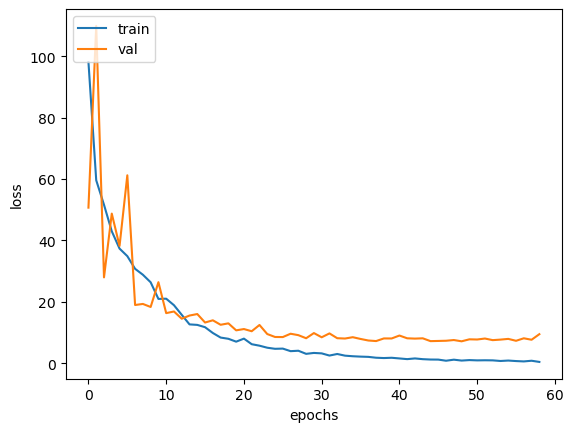

In [1669]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

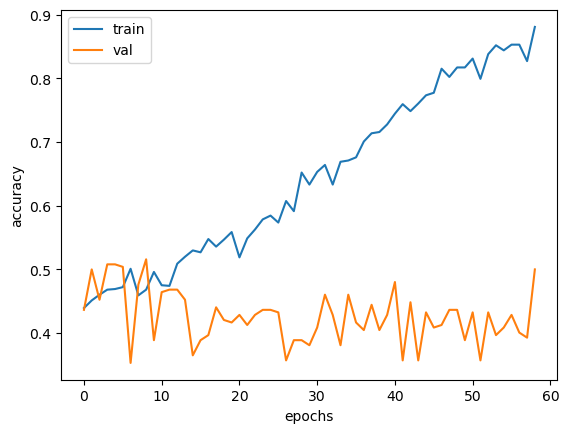

In [1670]:
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [1726]:
num_epochs = 30

In [1727]:
train_x,train_y = sp500_train.loc[:, lagged_indicators], sp500_train[['Target_Direction']].to_numpy()
train_x = train_x.loc[:, sorted_cols]
train_x_reshaped = np.array([np.transpose(row.reshape(2,14)) for row in train_x.to_numpy()])
encoder = OneHotEncoder()
train_y = encoder.fit_transform(train_y).todense()
train_x_reshaped.shape, train_y.shape

((1258, 14, 2), (1258, 3))

In [1728]:
tf.random.set_seed(0)

inputs = layers.Input(shape=(14,2), dtype=tf.float32)
x = layers.Conv1D(4, kernel_size=3, activation='relu')(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

model2 = tf.keras.Model(inputs, outputs)
model2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [1729]:
history2 = model2.fit(train_x_reshaped,
                      train_y,
                      epochs=num_epochs)

file_loc = f'{os.getcwd()}\Conv1DFC_validated_model'
tf.keras.models.save_model(model2, file_loc)

Epoch 1/30
40/40 [==============================] - 1s 3ms/step - loss: 3.6104 - accuracy: 0.4666
Epoch 2/30
40/40 [==============================] - 0s 3ms/step - loss: 1.2616 - accuracy: 0.5588
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 1.0250 - accuracy: 0.5795
Epoch 4/30
40/40 [==============================] - 0s 3ms/step - loss: 0.9495 - accuracy: 0.5874
Epoch 5/30
40/40 [==============================] - 0s 3ms/step - loss: 0.9121 - accuracy: 0.5851
Epoch 6/30
40/40 [==============================] - 0s 3ms/step - loss: 0.9012 - accuracy: 0.5930
Epoch 7/30
40/40 [==============================] - 0s 3ms/step - loss: 0.8967 - accuracy: 0.6002
Epoch 8/30
40/40 [==============================] - 0s 3ms/step - loss: 0.8945 - accuracy: 0.5954
Epoch 9/30
40/40 [==============================] - 0s 3ms/step - loss: 0.8883 - accuracy: 0.5986
Epoch 10/30
40/40 [==============================] - 0s 3ms/step - loss: 0.8886 - accuracy: 0.6010
Epoch 11/30
40/40 [

INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Conv1DFC_strategy\Conv1DFC_validated_model\assets


INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Conv1DFC_strategy\Conv1DFC_validated_model\assets


In [1730]:
test_x_reshaped.shape, test_y.shape

((1259, 14, 2), (1259, 3))

In [1731]:
test_preds_prob = model2.predict(test_x_reshaped)
test_preds = np.argmax(test_preds_prob, axis=1)-1
test_preds

40/40 [==============================] - 0s 2ms/step


array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [1732]:
sp500_test['prediction'] = test_preds
sp500_test

C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\476013826.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['prediction'] = test_preds


,High,Low,Open,Close,Volume,Adj Close,Close_1,Close_2,Close_3,Close_4,...,Volume_11,Volume_12,Volume_13,return,cumreturn,Close_Shifted,Target,Target_Direction,prediction,position
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,201.029999,198.589996,200.490005,201.020004,2223.535,178.051300,203.869995,205.929993,207.399994,205.210007,...,1970.170,1540.696,1823.852,NaN,NaN,193.660004,-6.241307,-1,1,1.0
2016-01-05,201.899994,200.050003,201.399994,201.360001,1108.458,178.352448,201.020004,203.869995,205.929993,207.399994,...,1730.925,1970.170,1540.696,0.001690,1.001691,188.830002,-3.231826,-1,1,0.0
2016-01-06,200.059998,197.600006,198.339996,198.820007,1521.126,176.102646,201.360001,201.020004,203.869995,205.929993,...,2513.935,1730.925,1970.170,-0.012694,0.989056,191.929993,-3.849897,-1,0,0.0
2016-01-07,197.440002,193.589996,195.330002,194.050003,2134.361,171.877686,198.820007,201.360001,201.020004,203.869995,...,990.943,2513.935,1730.925,-0.024284,0.965327,187.809998,-3.652854,-1,1,0.0
2016-01-08,195.850006,191.580002,195.190002,191.919998,2098.172,169.991058,194.050003,198.820007,201.360001,201.020004,...,1110.262,990.943,2513.935,-0.011037,0.954731,188.059998,-3.813274,-1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,264.579,359.978149,367.570007,367.239990,367.859985,369.179993,...,740.983,424.589,489.443,0.003883,1.835638,NaN,NaN,0,0,0.0
2020-12-28,372.589996,371.070007,371.739990,372.170013,390.004,363.070587,369.000000,367.570007,367.239990,367.859985,...,577.354,740.983,424.589,0.008554,1.851408,NaN,NaN,0,1,0.0
2020-12-29,374.000000,370.829987,373.809998,371.459991,536.805,362.377991,372.170013,369.000000,367.570007,367.239990,...,576.986,577.354,740.983,-0.001910,1.847876,NaN,NaN,0,0,0.0


Text(0.5, 1.0, 'Target')

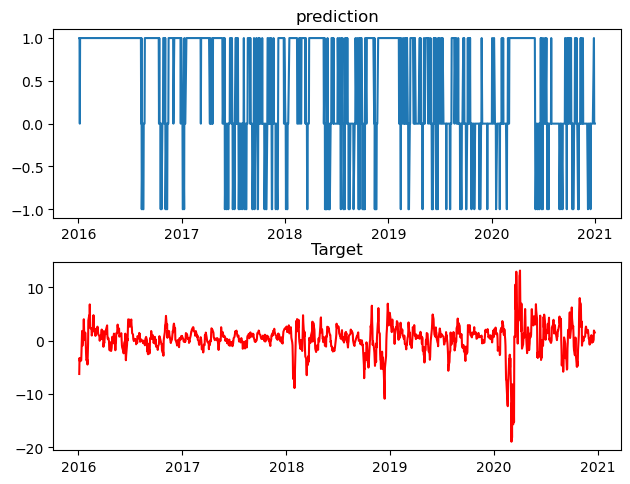

<Figure size 2000x1200 with 0 Axes>

In [1733]:
fig, ax = plt.subplots(2, 1)
plt.figure(figsize=(20,12))
fig.tight_layout()
ax[0].plot(pd.to_datetime(sp500_test.index).date, sp500_test['prediction'])
ax[0].set_title('prediction')
ax[1].plot(sp500_test.index, sp500_test['Target'], color='red')
ax[1].set_title('Target')

(array([117.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 477.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 665.]),
 array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
         0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <BarContainer object of 20 artists>)

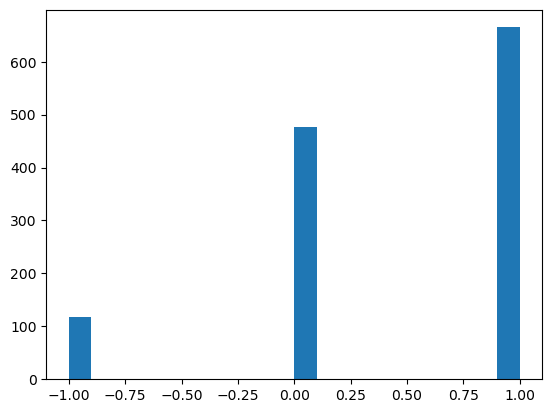

In [1734]:
plt.hist(sp500_test.prediction, bins=20)

In [1735]:
# def get_signal(prob, low=0.57, high=0.58):
#     if prob <= low:
#         return -1
#     elif prob >= high:
#         return 1
#     return 0

In [1736]:
# period = 7
# trade = False
# counter = 0
# position = []
# for i in range(len(sp500_test.index)):
#     prob = sp500_test.iloc[i]['prediction']
#     if trade == True:
#         if counter < period:
#             counter += 1
#             position.append(0)
#         else:
#             signal = get_signal(prob)
#             trade = True if signal != 0 else False
#             counter = 0
#             position.append(signal)
#     else:
#         signal = get_signal(prob)
#         trade = True if signal != 0 else False
#         position.append(signal)
# sp500_test['position'] = position
# sp500_test

In [1737]:
period = 7
trade = False
counter = 0
position = []
for i in range(len(sp500_test.index)):
    signal = sp500_test.iloc[i]['prediction']
    if trade == True:
        if counter < period:
            counter += 1
            position.append(0)
        else:
            trade = True if signal != 0 else False
            counter = 0
            position.append(signal)
    else:
        trade = True if signal != 0 else False
        position.append(signal)
sp500_test['position'] = position
sp500_test

C:\Users\kmlee\AppData\Local\Temp\ipykernel_11324\1162318339.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_test['position'] = position


,High,Low,Open,Close,Volume,Adj Close,Close_1,Close_2,Close_3,Close_4,...,Volume_11,Volume_12,Volume_13,return,cumreturn,Close_Shifted,Target,Target_Direction,prediction,position
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,201.029999,198.589996,200.490005,201.020004,2223.535,178.051300,203.869995,205.929993,207.399994,205.210007,...,1970.170,1540.696,1823.852,NaN,NaN,193.660004,-6.241307,-1,1,1.0
2016-01-05,201.899994,200.050003,201.399994,201.360001,1108.458,178.352448,201.020004,203.869995,205.929993,207.399994,...,1730.925,1970.170,1540.696,0.001690,1.001691,188.830002,-3.231826,-1,1,0.0
2016-01-06,200.059998,197.600006,198.339996,198.820007,1521.126,176.102646,201.360001,201.020004,203.869995,205.929993,...,2513.935,1730.925,1970.170,-0.012694,0.989056,191.929993,-3.849897,-1,0,0.0
2016-01-07,197.440002,193.589996,195.330002,194.050003,2134.361,171.877686,198.820007,201.360001,201.020004,203.869995,...,990.943,2513.935,1730.925,-0.024284,0.965327,187.809998,-3.652854,-1,1,0.0
2016-01-08,195.850006,191.580002,195.190002,191.919998,2098.172,169.991058,194.050003,198.820007,201.360001,201.020004,...,1110.262,990.943,2513.935,-0.011037,0.954731,188.059998,-3.813274,-1,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,369.029999,367.450012,368.079987,369.000000,264.579,359.978149,367.570007,367.239990,367.859985,369.179993,...,740.983,424.589,489.443,0.003883,1.835638,NaN,NaN,0,0,0.0
2020-12-28,372.589996,371.070007,371.739990,372.170013,390.004,363.070587,369.000000,367.570007,367.239990,367.859985,...,577.354,740.983,424.589,0.008554,1.851408,NaN,NaN,0,1,1.0
2020-12-29,374.000000,370.829987,373.809998,371.459991,536.805,362.377991,372.170013,369.000000,367.570007,367.239990,...,576.986,577.354,740.983,-0.001910,1.847876,NaN,NaN,0,0,0.0


In [1738]:
strategies = pd.DataFrame()
strategies['return'] = (sp500_test['Target']/100*sp500_test['position'] + 1).shift(7)
strategies['strategy'] = np.log(strategies['return'])
strategies['cumstrategy'] = strategies['strategy'].cumsum().apply(np.exp)
strategies

,return,strategy,cumstrategy
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN
...,...,...,...
2020-12-24,1.0,0.0,2.060801
2020-12-28,1.0,0.0,2.060801
2020-12-29,1.0,0.0,2.060801


In [1739]:
def plot_returns(benchmark, strategy, title):
    plt.figure(figsize=(20, 12))
    plt.plot(pd.to_datetime(strategy.index).date, strategy.cumstrategy, label='Model')
    plt.plot(benchmark.index, benchmark['cumreturn'], color='red', label='SP500 Buy & Hold')
    plt.title(title)
    plt.gca().grid(True)
    plt.legend()

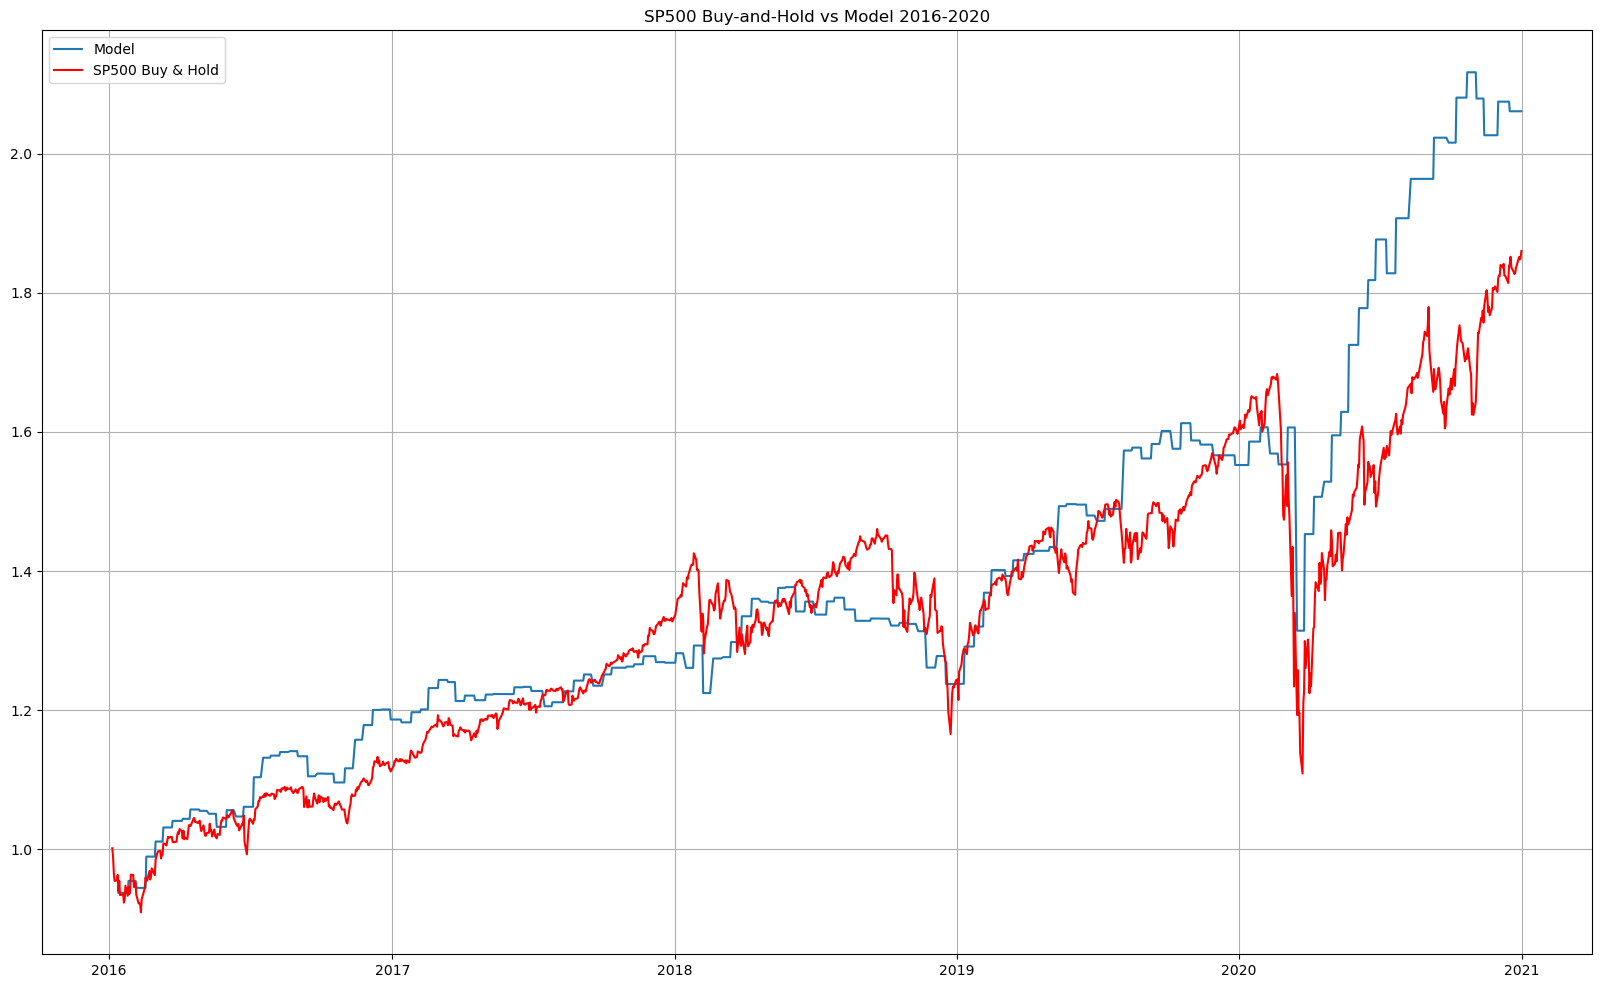

In [1740]:
plot_returns(sp500_test, strategies, 'SP500 Buy-and-Hold vs Model 2016-2020')

In [1745]:
hits = np.where((sp500_test['Target_Direction'] == sp500_test['prediction']) &
                (sp500_test['position'] != 0) &
                (sp500_test['Target'].isnull() == False), 1, 0)
np.sum(hits)/len(sp500_test[(sp500_test.position != 0) & (sp500_test.Target.isnull()==False)])*100

53.191489361702125

In [1742]:
sp500_weekly = sp500_test.copy()
sp500_weekly['buy hold position'] = np.where(sp500_weekly.position != 0, 1, 0)
sp500_weekly['buy hold return'] = (sp500_weekly['buy hold position']*sp500_weekly['Target']/100 + 1).shift(7)
sp500_sharpe = sp500_weekly.loc[sp500_weekly['buy hold return'] != 1, 'buy hold return'].mean()/sp500_weekly.loc[sp500_weekly['buy hold return'] != 1, 'buy hold return'].std()
sp500_sharpe

37.20731219616477

In [1743]:
strategy_sharpe = strategies.loc[strategies['return'] != 1, 'return'].mean()/strategies.loc[strategies['return'] != 1, 'return'].std()
strategy_sharpe

37.65021116839532